## 1. Import the required libraries

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = 'False'
import sys
import configparser

import numpy as np
import matplotlib.pyplot as plt

import re
import random
from tqdm import tqdm
from functools import partial

import torch
from torch.backends import cudnn

import torchvision
from torchvision import transforms

sys.path.insert(0, '../MODULES')
from DENOISING_DIFFUSION_PYTORCH import Unet, GaussianDiffusion

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## 2. Write device agnostic code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device)

Device is: cuda


## 3. Fix hyperparameters

In [3]:
config = configparser.ConfigParser()

config['diffusion_model'] = {'rand_seed': 76543, 'n_pix': 128, 'batch_size': 10, 'learning_rate': 1e-4, 'h_dim': 64,
                             'dim_mults': [1, 2, 4, 8], 'self_condition': False, 'timesteps': 1000}

config.write(sys.stdout)

[diffusion_model]
rand_seed = 76543
n_pix = 128
batch_size = 10
learning_rate = 0.0001
h_dim = 64
dim_mults = [1, 2, 4, 8]
self_condition = False
timesteps = 1000



## 4. Set hyperparameters

In [4]:
rand_seed = int(config['diffusion_model']['rand_seed'])

random.seed(rand_seed)
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
torch.random.manual_seed(rand_seed)

if device == 'cuda':
    torch.cuda.manual_seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)

torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [5]:
n_pix         = int(config['diffusion_model']['n_pix'])
batch_size    = int(config['diffusion_model']['batch_size'])
learning_rate = float(config['diffusion_model']['learning_rate'])
h_dim         = int(config['diffusion_model']['h_dim'])

In [6]:
match = re.search('\[(.*)\]', config['diffusion_model']['dim_mults'])
dim_mults = re.split(',\s*', match[1])
dim_mults = [int(i) for i in dim_mults]

In [7]:
self_condition = bool(config['diffusion_model']['self_condition'])
timesteps      = int(config['diffusion_model']['timesteps'])

## 5. Instantiate Unet

In [8]:
model = Unet(dim=h_dim, dim_mults=dim_mults, self_condition=self_condition, flash_attn=True)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


## 6. Instantiate diffusion model

In [9]:
diffusion = GaussianDiffusion(model, image_size=n_pix, timesteps=timesteps, objective='pred_x0', beta_schedule='cosine',
                              auto_normalize=False).to(device)

## 7. Load dataset

In [10]:
dir_src = '/project/dsc-is/nono/Documents/kpc/dat0'
data_src = 'slice128_Block2_11K.npy'

print(os.path.join(dir_src, data_src))

pix_src = np.load(os.path.join(dir_src, data_src))
pix_src = pix_src[:, 0, :, :, :]

print(pix_src.shape)
n_sample, nx, ny, nc = pix_src.shape

/project/dsc-is/nono/Documents/kpc/dat0/slice128_Block2_11K.npy
(11000, 128, 128, 3)


## 8. Custom function to create a list of batches

In [11]:
def make_batch_list(idx, n_batch=10, batch_size=None, shuffle=True):
    if shuffle:
        np.random.shuffle(idx)
    if (batch_size is not None):
        n_batch = len(idx) // batch_size
    batch_list = np.array_split(idx, n_batch)
    return batch_list

## 9. Custom function to extract samples in batches

In [12]:
transform_pix = transforms.Compose([transforms.ToTensor()])

def generate_batch(idx, pix_src):
    tmp = []
    for ii in idx:
        xxx = transform_pix(pix_src[ii])
        tmp.append(xxx)
    xxx_batch = torch.stack(tmp, dim=0)
    return xxx_batch

## 10. Load diffusion model

In [13]:
dir_save = '../P2'

path_model = os.path.join(dir_save, 'model_ddpm.20240508.150.ckpt')
path_hist = os.path.join(dir_save, 'hist_ddpm.20240508.150.tsv')

diffusion.model.load_state_dict(torch.load(path_model, weights_only=True))

<All keys matched successfully>

## 11. Forward process output

In [14]:
idx_trn = np.arange(n_sample)
batch_list = make_batch_list(idx_trn, batch_size=batch_size, shuffle=False)
xxx_tmp = generate_batch(batch_list[0], pix_src)
xxx_tmp = xxx_tmp.to(device)

In [15]:
img = torch.randn(10, 3, 128, 128).to(device)
clip_func = partial(torch.clamp, min=0., max=1.)

In [16]:
times = np.arange(0, 1001)
time_pairs = list(zip(times[:-1], times[1:]))

In [17]:
img_seq = []
img_seq.append(xxx_tmp.cpu().detach().numpy())

for time, time_next in tqdm(time_pairs, desc='forward_process_output'):
    time_cond = torch.full((batch_size,), time, dtype=torch.long).to(device)
    
    model_output = model(img, time_cond, None)
        
    x_start = model_output
    x_start = clip_func(x_start)
    pred_noise = diffusion.predict_noise_from_start(x_start, time_cond, xxx_tmp)
    
    if (time+1) % 100 == 0:
        img_seq.append(pred_noise.detach().cpu().numpy())

forward_process_output: 100%|███████████████████████████████████| 1000/1000 [00:57<00:00, 17.26it/s]


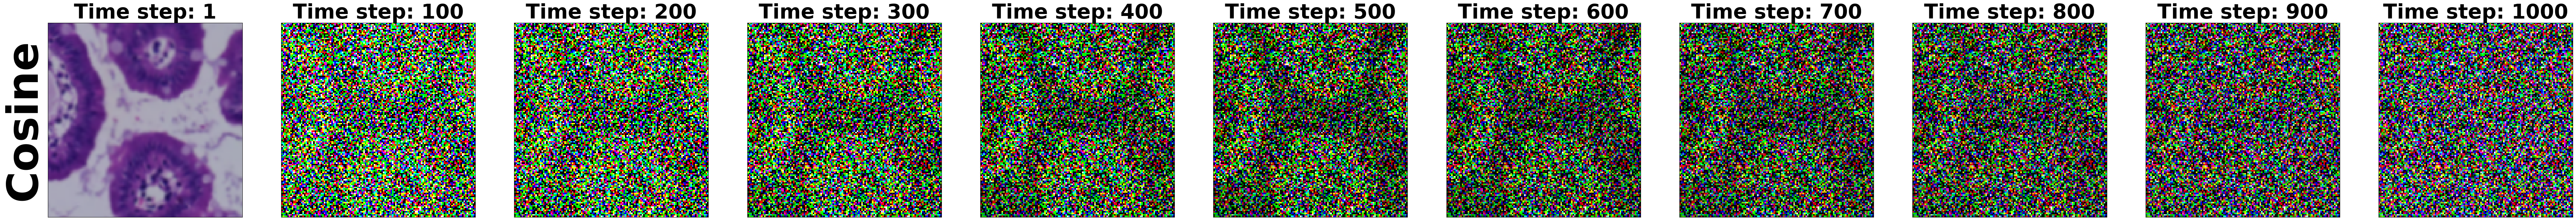

In [18]:
step = [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for p, q in enumerate(img_seq):
    ax[p].imshow(np.clip(q[3], 0, 1).transpose())
    ax[p].set_title(f'Time step: {step[p]}', fontsize=45, fontweight='bold')
    ax[0].set_ylabel('Cosine', fontsize=95, fontweight='bold')
    ax[p].set_xticks([])
    ax[p].set_yticks([]);